# Quantium virtual internship - Retail strategy and analytics

This file is a solution of the Quantium Internship task 1.

In [7]:
# !pip install datatable
# !pip install jupyterlab ipywidgets
import pandas as pd
import numpy as np
import datatable as dt
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import re
sns.set_style("whitegrid")
sns.set_palette("RdBu")

customerData = dt.fread('/content/drive/MyDrive/Colab Notebooks/Quantium/Task1/QVI_purchase_behaviour.csv').to_pandas()
transactionData = dt.fread('/content/drive/MyDrive/Colab Notebooks/Quantium/Task1/QVI_transaction_data.xlsx').to_pandas()

Mounted at /content/drive


## Exploratory data analysis
The first step in any analysis is to first understand the data. Let's take a look
at each of the datasets provided.

In [8]:
#Examining transaction data
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


Let's check if columns we would expect to be numeric are in numeric form and date.

In [9]:
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int32  
 1   STORE_NBR       264836 non-null  int32  
 2   LYLTY_CARD_NBR  264836 non-null  int32  
 3   TXN_ID          264836 non-null  int32  
 4   PROD_NBR        264836 non-null  int32  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int32  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int32(6), object(1)
memory usage: 10.1+ MB


We can see that the date column is in an integer format. Let's change this to a
date format.

In [10]:
#### Convert DATE column to a date format
transactionData['DATE'] = pd.to_datetime(transactionData['DATE'], origin = pd.Timestamp('1899-12-30'),unit='D')
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int32         
 2   LYLTY_CARD_NBR  264836 non-null  int32         
 3   TXN_ID          264836 non-null  int32         
 4   PROD_NBR        264836 non-null  int32         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int32         
 7   TOT_SALES       264836 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(5), object(1)
memory usage: 11.1+ MB


We should check that we are looking at the right products by examining PROD_NAME. Looks like we are definitely looking at potato chips but how can we check that
these are all chips? We can do some basic text analysis by summarising the
individual words in the product name.

In [11]:
# Examine the words in PROD_NAME to see if there are any incorrect entries
# such as products that are not chips
transactionData['PROD_NAME'].unique()[:10,]

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G'], dtype=object)

As we are only interested in words that will tell us if the product is chips or
not, let's remove all words with digits and special characters such as '&' from our
set of product words. Then look at the most common words by counting the number of times a word appears and sorting them by this frequency in order of highest to lowest frequency

In [12]:
from collections import Counter

# Create text cleaning function for PROD_NAME feature
def clean_text(text):
    text = re.sub('[&/]', ' ', text)
    text = re.sub('\d\w*', ' ', text) 
    return str(text)

# Apply text cleaning function to PROD_NAME column
ar = transactionData['PROD_NAME'].apply(clean_text).unique()
# Create bag of works
bag_of_word = [word for x in ar for word in x.split()]
pd.DataFrame.from_dict(Counter(bag_of_word), orient='index', columns=["frequency"]).sort_values('frequency', ascending=False).head(20)

,frequency
Chips,21
Smiths,16
Crinkle,14
Cut,14
Kettle,13
Salt,12
Cheese,12
Original,10
Doritos,9
Chip,9


There are salsa products in the dataset but we are only interested in the chips
category, so let's remove these.

In [13]:
#### Remove salsa products
transactionData = transactionData.loc[~transactionData['PROD_NAME'].str.lower().str.contains('salsa')]

Next, we check summary statistics such as mean, min and max
values or null for each feature to see if there are any obvious outliers in the data.

In [14]:
display(transactionData.describe())
print(transactionData.isna().any())

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


DATE              False
STORE_NBR         False
LYLTY_CARD_NBR    False
TXN_ID            False
PROD_NBR          False
PROD_NAME         False
PROD_QTY          False
TOT_SALES         False
dtype: bool


There are no nulls in the columns but product quantity appears to have an outlier which we should investigate further. Let's investigate further the case where 200 packets of chips are bought in one transaction.

In [15]:
#### Filter the dataset to find the outlier
transactionData.loc[transactionData['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


There are two transactions where 200 packets of chips are bought in one transaction
and both of these transactions were by the same customer.

In [16]:
#### Let's see if the customer has had other transactions
transactionData['LYLTY_CARD_NBR'] == 226000

0         False
1         False
2         False
3         False
4         False
          ...  
264831    False
264832    False
264833    False
264834    False
264835    False
Name: LYLTY_CARD_NBR, Length: 246742, dtype: bool

It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. We'll remove this loyalty card number from further analysis.

In [17]:
#### Filter out the customer based on the loyalty card number
transactionData = transactionData.loc[transactionData['LYLTY_CARD_NBR'] != 226000]
#### Re-examine transaction data
transactionData.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
std,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


That's better. Now, let's look at the number of transaction lines over time to see
if there are any obvious data issues such as missing data.


In [18]:
#### Count the number of transactions by date
transactionData.groupby("DATE").count().shape[0]

364

There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
chart of number of transactions over time to find the missing date.


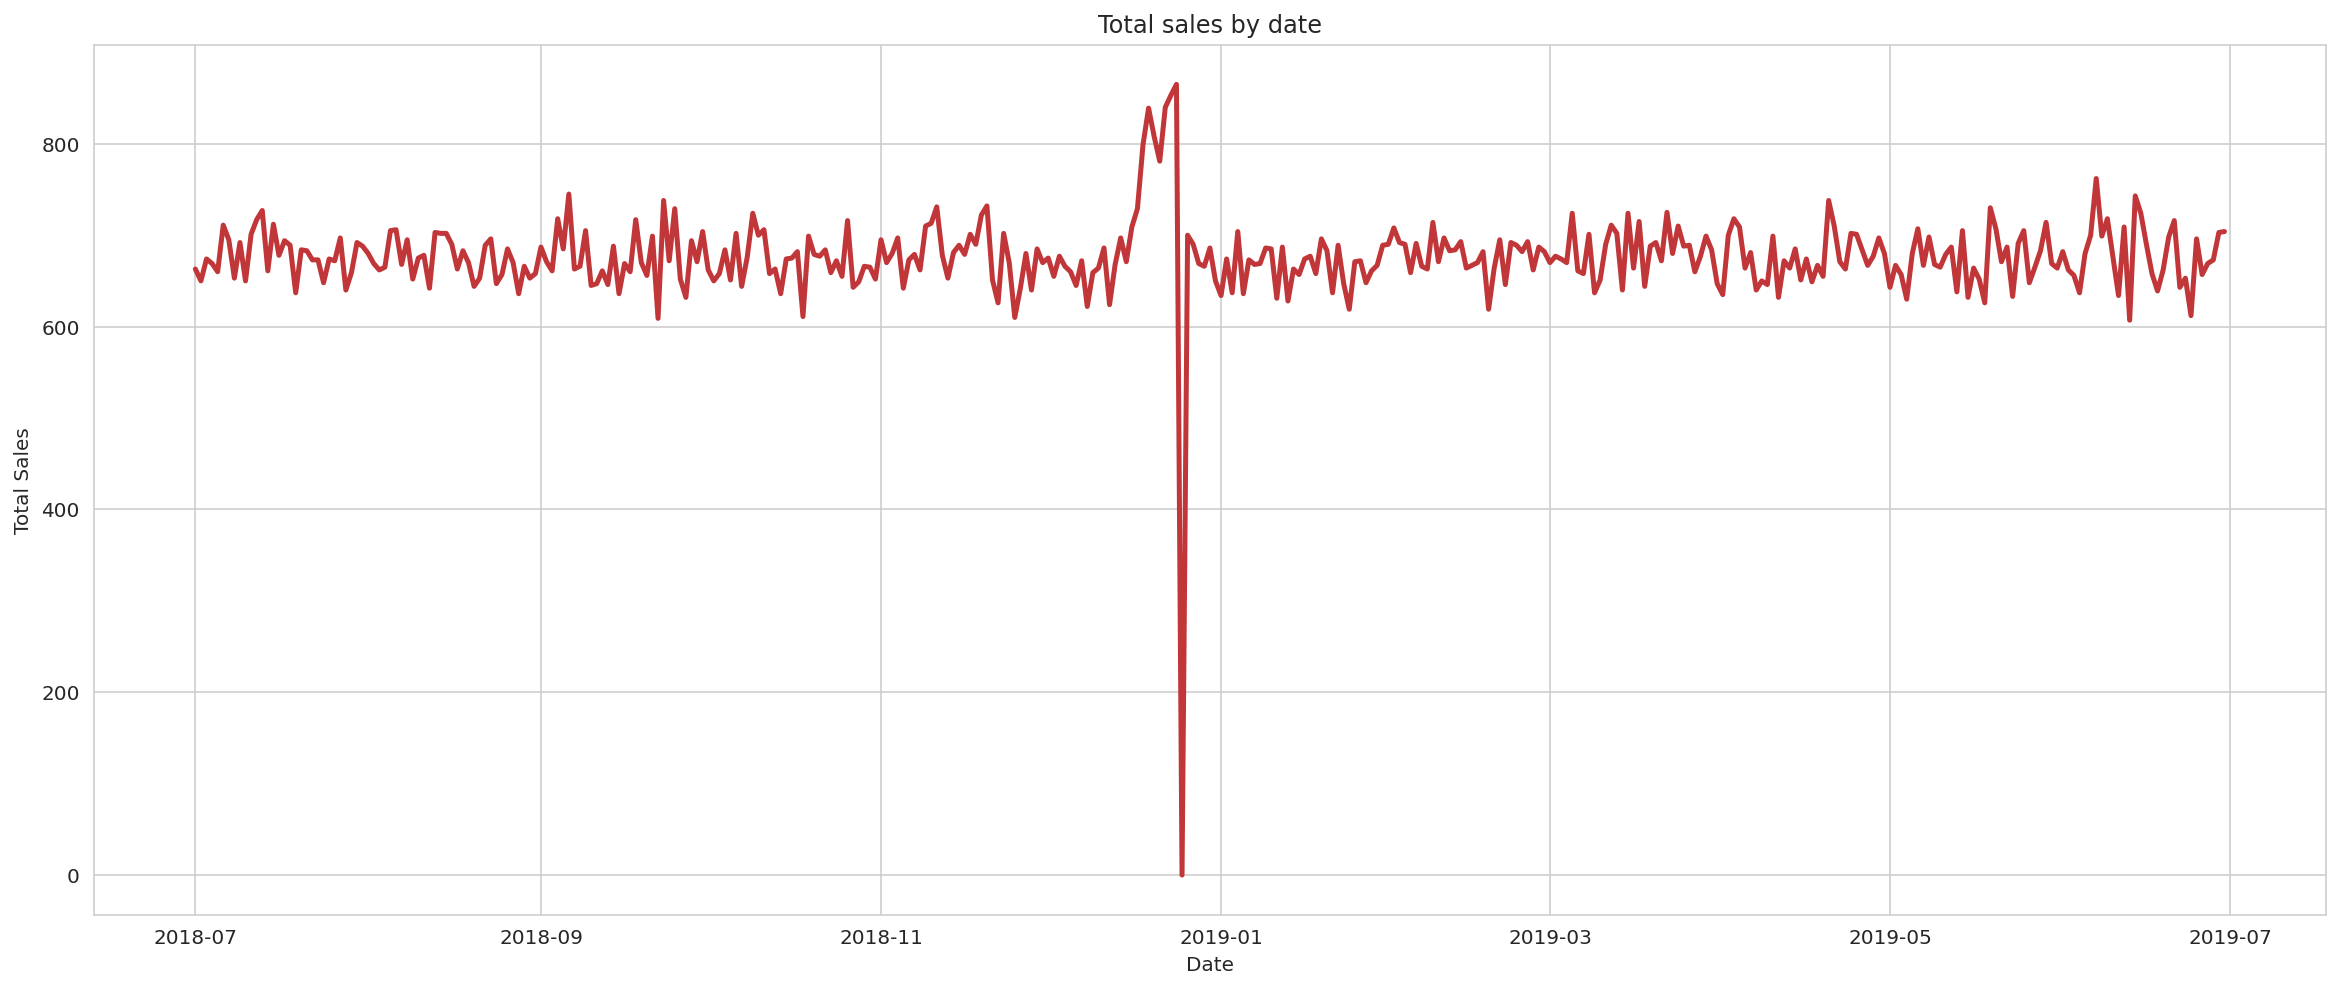

In [19]:
transactions_by_date = transactionData.groupby(['DATE'])['TOT_SALES'].count()
idx = pd.date_range('2018-07-01', '2019-06-30')
transactions_by_date = transactions_by_date.reindex(idx, fill_value=0)
plt.subplots(figsize=(20,8), dpi=144)
sns.lineplot(data=transactions_by_date, palette="tab10", linewidth=2.5)
plt.title("Total sales by date")
plt.xlabel("Date")
plt.ylabel('Total Sales')
plt.show()

We can see that there is an increase in purchases in December and a break in late
December. Let's zoom in on this.

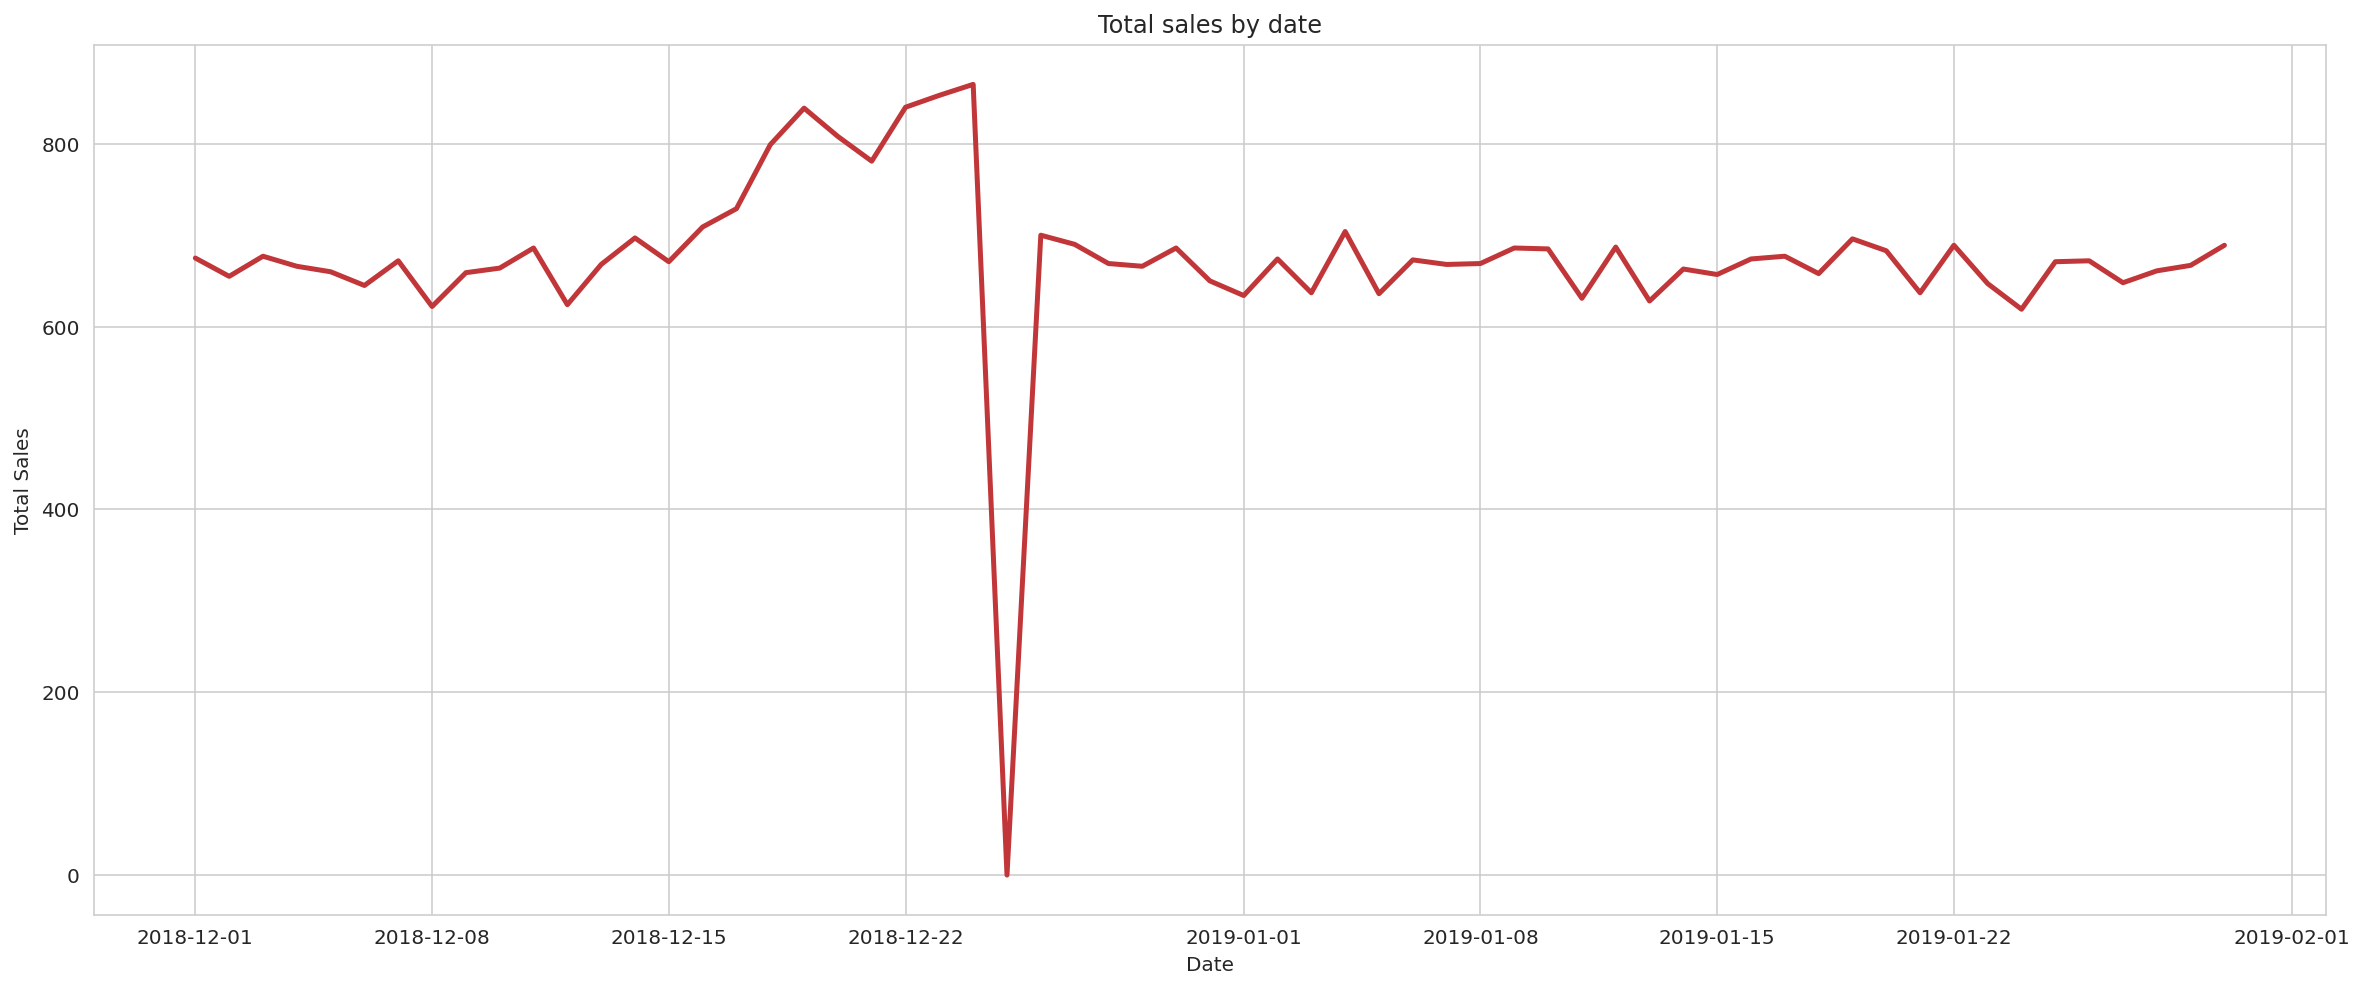

In [20]:
#### Filter to December and look at individual days
transactions_by_date = transactionData.groupby(['DATE'])['TOT_SALES'].count()
idx = pd.date_range('2018-12-01', '2019-01-30')
transactions_by_date = transactions_by_date.reindex(idx, fill_value=0)
plt.subplots(figsize=(20,8), dpi=144)
sns.lineplot(data=transactions_by_date, palette="tab10", linewidth=2.5)
plt.title("Total sales by date")
plt.xlabel("Date")
plt.ylabel('Total Sales')
plt.show()

We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.
Now that we are satisfied that the data no longer has outliers, we can move on to
creating other features such as brand of chips or pack size from PROD_NAME. We will
start with pack size.

In [21]:
#### Pack size
def get_size(text):
    text = re.sub('[&/]', '', text)
    size = re.sub('\D', '', text)
    return(int(size))

transactionData['PACK_SIZE'] = transactionData.apply(lambda x: get_size(x['PROD_NAME']), axis="columns")
transactionData.sort_values('PACK_SIZE', ascending=False)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
139622,2018-12-12,70,70132,68251,4,Dorito Corn Chp Supreme 380g,2,13.0,380
32144,2019-05-18,40,40026,36227,14,Smiths Crnkle Chip Orgnl Big Bag 380g,1,5.9,380
67137,2018-11-30,223,223113,223590,4,Dorito Corn Chp Supreme 380g,2,13.0,380
249038,2018-10-13,142,142256,143109,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380
206337,2019-01-02,47,47439,42948,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380
...,...,...,...,...,...,...,...,...,...
189801,2018-09-18,67,67252,65334,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70
50822,2019-03-31,213,213184,213111,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70
154828,2018-11-10,55,55143,49325,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70
109817,2018-12-23,152,152069,150667,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70


The largest size is 380g and the smallest size is 70g - seems sensible!

Next, let's plot a histogram of PACK_SIZE since we know that it is a categorical 
variable and not a continuous variable even though it is numeric.

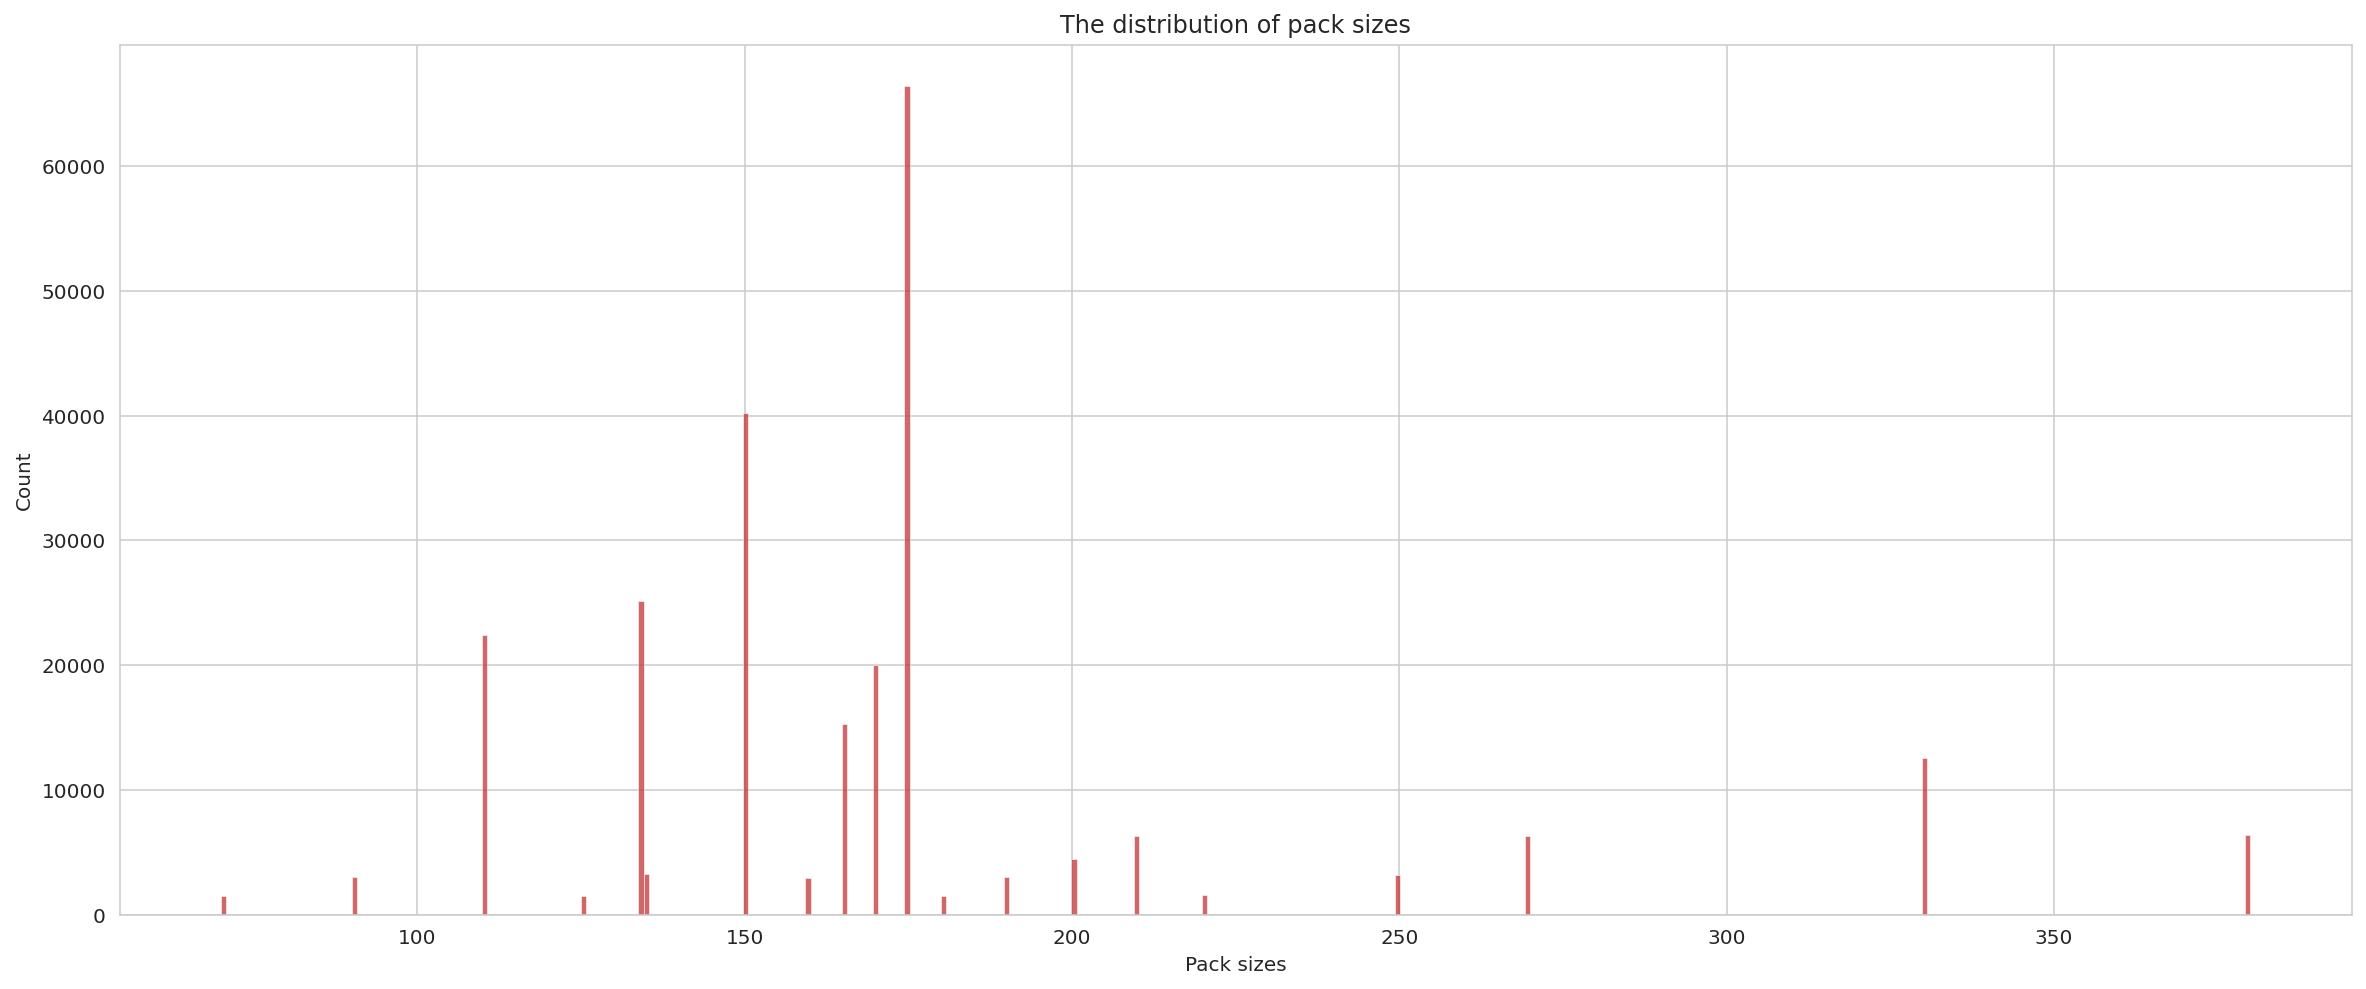

In [22]:
plt.subplots(figsize=(20,8), dpi=144)
sns.histplot(
    transactionData['PACK_SIZE']
)
plt.title("The distribution of pack sizes")
plt.xlabel("Pack sizes")
plt.show()

Pack sizes created look reasonable.
Now to create brands, we can use the first word in PROD_NAME to work out the brand name...

In [23]:
def get_brand(text):
    text = re.sub('[&/]', ' ', text)
    return(text.split()[0])

transactionData['BRANDS'] = transactionData.apply(lambda x: get_brand(x['PROD_NAME']), axis="columns")
print(np.sort(transactionData['BRANDS'].unique()))

['Burger' 'CCs' 'Cheetos' 'Cheezels' 'Cobs' 'Dorito' 'Doritos' 'French'
 'Grain' 'GrnWves' 'Infuzions' 'Infzns' 'Kettle' 'NCC' 'Natural'
 'Pringles' 'RRD' 'Red' 'Smith' 'Smiths' 'Snbts' 'Sunbites' 'Thins'
 'Tostitos' 'Twisties' 'Tyrrells' 'WW' 'Woolworths']


Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red Rock Deli chips. Let's combine these together.


In [24]:
transactionData.loc[(transactionData.BRANDS == 'WW'),'BRANDS'] = 'Woolworths'
transactionData.loc[(transactionData.BRANDS == 'RRD'),'BRANDS'] = 'Red'
transactionData.loc[(transactionData.BRANDS == 'Snbts'),'BRANDS'] = 'Smiths'
transactionData.loc[(transactionData.BRANDS == 'Infzns'),'BRANDS'] = 'Infuzions'
transactionData.loc[(transactionData.BRANDS == 'NCC'),'BRANDS'] = 'Natural'
transactionData.loc[(transactionData.BRANDS == 'GrnWves'),'BRANDS'] = 'Grain'
transactionData.loc[(transactionData.BRANDS == 'Smith'),'BRANDS'] = 'Smiths'
transactionData.loc[(transactionData.BRANDS == 'Dorito'),'BRANDS'] = 'Doritos'
#### Check again
print(np.sort(transactionData['BRANDS'].unique()))

['Burger' 'CCs' 'Cheetos' 'Cheezels' 'Cobs' 'Doritos' 'French' 'Grain'
 'Infuzions' 'Kettle' 'Natural' 'Pringles' 'Red' 'Smiths' 'Sunbites'
 'Thins' 'Tostitos' 'Twisties' 'Tyrrells' 'Woolworths']


Now that we are happy with the transaction dataset, let's have a look at the customer dataset. First, let's take a look at the dataset.

In [25]:
#### Examining customer data
display(customerData.head())
display(customerData.info())
print( "\nAre there any duplicate ? \n" + str(customerData.duplicated().any()))

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int32 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int32(1), object(2)
memory usage: 1.4+ MB


None


Are there any duplicate ? 
False


Seem like there are no missing values and all columns are in the right format. Now we check the distribution of of Lifestate and premium_customer.

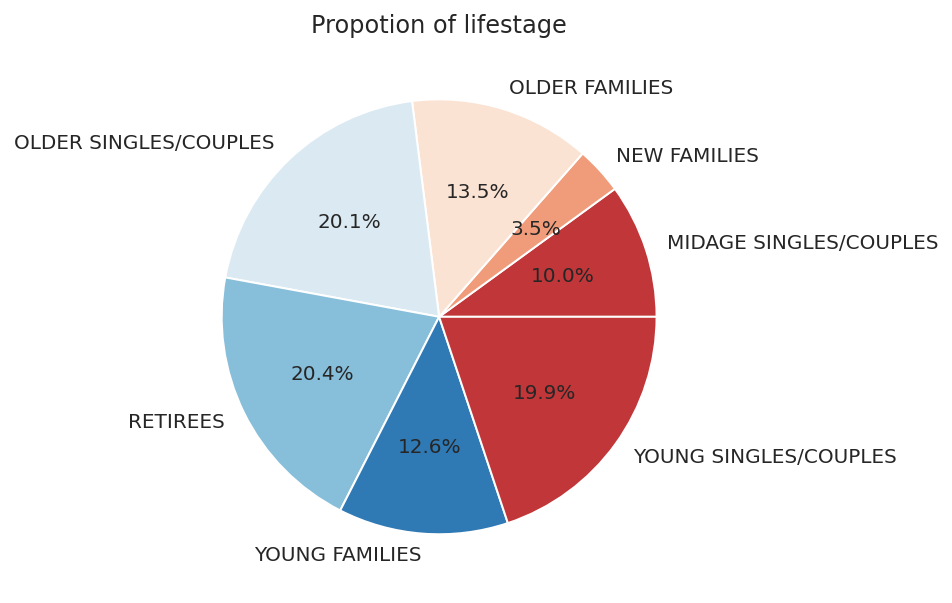

In [26]:
df = customerData.groupby('LIFESTAGE').count()
plt.subplots(figsize=(5,5), dpi=144)
plt.pie(df['LYLTY_CARD_NBR'], labels=df.index, autopct='%1.1f%%')
plt.title("Propotion of lifestage")
plt.show()

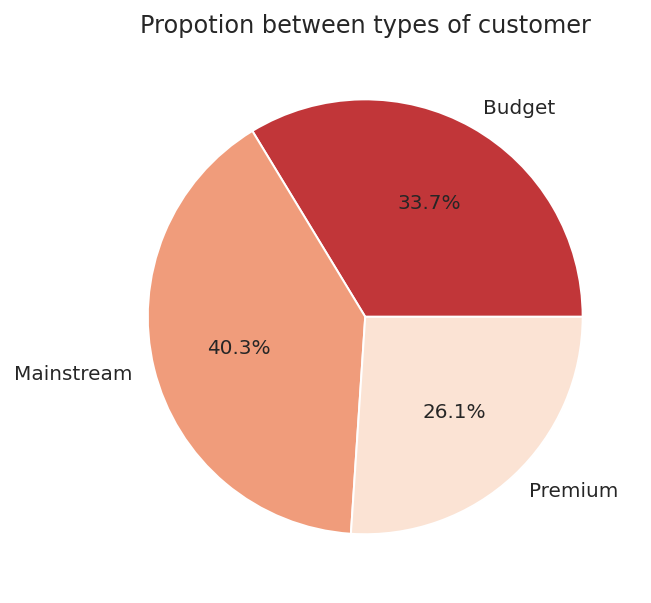

In [27]:
# Propotion of LIFESTAGES
df = customerData.groupby('PREMIUM_CUSTOMER').count()
plt.subplots(figsize=(5,5), dpi=144)
plt.pie(df['LYLTY_CARD_NBR'], labels=df.index, autopct='%1.1f%%')
plt.title('Propotion between types of customer')
plt.show()

In [28]:
#### Merge transaction data to customer data
data = pd.merge(transactionData, customerData, how="left", on="LYLTY_CARD_NBR")
data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRANDS,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,Kettle,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,Tostitos,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,Doritos,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,Doritos,YOUNG SINGLES/COUPLES,Premium


As the number of rows in `data` is the same as that of `transactionData`, we can be sure that no duplicates were created. This is because we created `data` by a left join. Which means take all the rows in `transactionData` and find rows with matching values in shared columns and then joining the details in these rows to the `x` or the first mentioned table.


Let's also check if some customers were not matched on by checking for nulls.

In [29]:
data.isnull().any()

DATE                False
STORE_NBR           False
LYLTY_CARD_NBR      False
TXN_ID              False
PROD_NBR            False
PROD_NAME           False
PROD_QTY            False
TOT_SALES           False
PACK_SIZE           False
BRANDS              False
LIFESTAGE           False
PREMIUM_CUSTOMER    False
dtype: bool

Great, there are no nulls! So all our customers in the transaction data has been accounted for in the customer dataset. Write this dataset out as a csv.


In [30]:
data.to_csv("QVI_data.csv")

Data exploration is now complete!

## Data analysis on customer segments
Now that the data is ready for analysis, we can define some metrics of interest to the client:
- Who spends the most on chips (total sales), describing customers by lifestage and
how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment

We could also ask our data team for more information. Examples are:
- The customer's total spend over the period and total spend for each transaction to understand what proportion of their grocery spend is on chips
- Proportion of customers in each customer segment overall to compare against the mix of customers who purchase chips
Let's start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and
plotting the split by these segments to describe which customer segment contribute
most to chip sales.

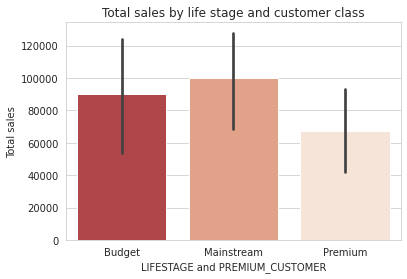

In [56]:
#### Total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales_by_lfstg_precus = data.pivot_table("TOT_SALES", 'LIFESTAGE', 'PREMIUM_CUSTOMER', aggfunc=np.sum)
ax = sns.barplot(data=sales_by_lfstg_precus)
ax.set_title("Total sales by life stage and customer class")
ax.set_xlabel("LIFESTAGE and PREMIUM_CUSTOMER")
ax.set_ylabel("Total sales")
plt.show()

Sales are coming mainly from Budget - older families, Mainstream - young
singles/couples, and Mainstream - retirees

Let's see if the higher sales are due to there being more customers who buy chips.

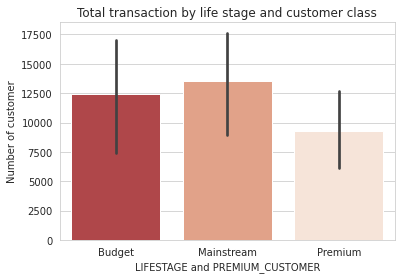

In [58]:
#### Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
count_by_lfstg_precus = data.pivot_table(values="LYLTY_CARD_NBR", index="LIFESTAGE", columns="PREMIUM_CUSTOMER", aggfunc="count")
ax = sns.barplot(data=count_by_lfstg_precus)
ax.set_title("Total transaction by life stage and customer class")
ax.set_xlabel("LIFESTAGE and PREMIUM_CUSTOMER")
ax.set_ylabel("Number of customer")
plt.show()

There are more Mainstream - young singles/couples and Mainstream - retirees who buy
chips. This contributes to there being more sales to these customer segments but
this is not a major driver for the Budget - Older families segment.
Higher sales may also be driven by more units of chips being bought per customer. Let's have a look at this next.


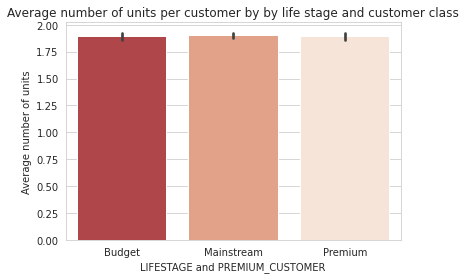

In [59]:
#### Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_unit_by_lfstg_precus = data.pivot_table(values="PROD_QTY", index="LIFESTAGE", columns="PREMIUM_CUSTOMER", aggfunc="mean")
ax = sns.barplot(data=avg_unit_by_lfstg_precus)
ax.set_title("Average number of units per customer by by life stage and customer class")
ax.set_xlabel("LIFESTAGE and PREMIUM_CUSTOMER")
ax.set_ylabel("Average number of units")
plt.show()

Older families and young families in general buy more chips per customer.

Let's also investigate the average price per unit chips bought for each customer segment as this is also a driver of total sales.

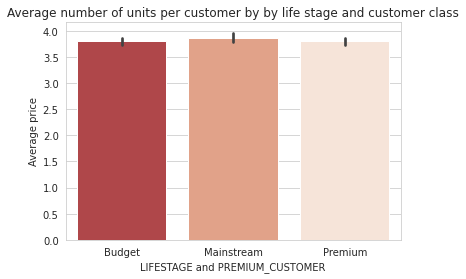

In [50]:
#### Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
data['UNT_PRC'] = data['TOT_SALES'] / data['PROD_QTY']
avg_unit_by_lfstg_precus = data.pivot_table(values="UNT_PRC", index="LIFESTAGE", columns="PREMIUM_CUSTOMER", aggfunc="mean")
ax = sns.barplot(data=avg_unit_by_lfstg_precus)
ax.set_title("Average number of units per customer by by life stage and customer class")
ax.set_xlabel("LIFESTAGE and PREMIUM_CUSTOMER")
ax.set_ylabel("Average price")
plt.show()

Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

As the difference in average price per unit isn't large, we can check if this is statistically different.

In [60]:
#### Perform an independent t-test between mainstream vs premium and budget midage and young singles and couples
import scipy.stats as stats

mainstream = data.loc[(data['LIFESTAGE'].isin(["MIDAGE SINGLES/COUPLES","YOUNG SINGLES/COUPLES"])) & 
                        (data['PREMIUM_CUSTOMER'] == "Mainstream") ]

Premium = data.loc[(data['LIFESTAGE'].isin(["MIDAGE SINGLES/COUPLES","YOUNG SINGLES/COUPLES"])) & 
                        (data['PREMIUM_CUSTOMER'] == "Premium") ]

Budget = data.loc[(data['LIFESTAGE'].isin(["MIDAGE SINGLES/COUPLES","YOUNG SINGLES/COUPLES"])) & 
                        (data['PREMIUM_CUSTOMER'] == "Budget") ]

anova = stats.f_oneway(mainstream['UNT_PRC'], Premium['UNT_PRC'], Budget['UNT_PRC'])
print(anova)

F_onewayResult(statistic=719.8864775728413, pvalue=1.645620823842387e-309)


The t-test results in a p-value < 0.05 we do not reject hypothesis, i.e. the unit price for mainstream, young and mid-age singles and couples ARE NOT significantly higher than that of budget or premium, young and midage singles and couples.


## Deep dive into specific customer segments for insights
We have found quite a few interesting insights that we can dive deeper into.

We might want to target customer segments that contribute the most to sales to retain them or further increase sales. Let's look at Mainstream - young singles/couples. For instance, let's find out if they tend to buy a particular brand of chips.

In [61]:
#### Deep dive into Mainstream, young singles/couples
from mlxtend.frequent_patterns import apriori, association_rules

basket = (data[(data['PREMIUM_CUSTOMER'] =="Mainstream") & (data['LIFESTAGE'] =="YOUNG SINGLES/COUPLES")]
          .groupby(['TXN_ID', 'BRANDS'])['PROD_QTY']
          .sum().unstack().reset_index().fillna(0)
          .set_index('TXN_ID'))

def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# Encoding the datasets
basket_encoded = basket.applymap(hot_encode)
basket = basket_encoded

# Building the model
frq_items = apriori(basket, min_support = 0.05, use_colnames = True)
frq_items.sort_values('support', ascending=False)

,support,itemsets
2,0.197310,(Kettle)
0,0.122061,(Doritos)
3,0.118828,(Pringles)
4,0.102197,(Smiths)
1,0.064110,(Infuzions)
5,0.059850,(Thins)


We can see that Kettle is the most popular chip brand for Mainstream, young singles/couples. Doritos and Pringles are following right behind.
Let's also find out if our target segment tends to buy larger packs of chips.


In [62]:
#### Preferred pack size compared to the rest of the population
basket = (data[(data['PREMIUM_CUSTOMER'] =="Mainstream") & (data['LIFESTAGE'] =="YOUNG SINGLES/COUPLES")]
          .groupby(['TXN_ID', 'PACK_SIZE'])['PROD_QTY']
          .sum().unstack().reset_index().fillna(0)
          .set_index('TXN_ID'))

def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# Encoding the datasets
basket_encoded = basket.applymap(hot_encode)
basket = basket_encoded

# Building the model
frq_items = apriori(basket, min_support = 0.05, use_colnames = True)
frq_items.sort_values('support', ascending=False)

,support,itemsets
5,0.256288,(175)
2,0.157992,(150)
1,0.118828,(134)
0,0.105225,(110)
4,0.080741,(170)
6,0.061339,(330)
3,0.056565,(165)


175g is the most favorited pack size.